In [1]:
import re
import os
import numpy as np
import pandas as pd
import random
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

Median radius ~ 400 nm
Ln(GSD) ~ 0.262
V ~ 24.5 um3/cc
DEHS particles (refractive index = 1.45 + 1e-5i at 532 nm)

These results are for different median size cases, namely, 200 nm, 400 nm, 600 nm and 800 nm. I included another CSV file that has the average number concentration with unit of #/cc. The GSD for these experiment are not exactly known but it is most likely between 1.05 to 1.1. Note that the unit for phase function is 1/Mm 1/str.

n addition to these narrow phase function data, I included another CSV file that has the phase function for a measurement conducted for broad size distribution with median size of 400 nm and GSD 1.4. This could already be included in the current ML model as its GSD is within the training range. Note that both phase function (P11) and polarized phase function (PPF) are include in the same csv file for the broad 400 nm data.
 
 

# Open Data

In [2]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
#directory1 = '/data/project/general/aerosolretriev/aerosol_results_rb/simulated_data/paper_results_gaussian_AAE/'
directory = '/data/project/general/aerosolretriev/aerosol_results_rb/simulated_data/real_meas_scan_532'
directory1 = '/data/project/general/aerosolretriev/aerosol_results_rb/simulated_data/real_meas_scans'

In [4]:
#plot_dir = directory1 + 'version13/plots/measurement_data'
#if not os.path.exists(plot_dir):
#    os.makedirs(plot_dir)

model_dir_fwiv = directory + '/model'
model_dir_fw = directory1 + '/forward_model_fw1'
model_dir_iv = directory1 + '/forward_model_iv1'


In [5]:
model_name_fwiv = 'invertible_model'
model_name_fw = 'best_model1'
model_name_iv = 'best_model1'

In [6]:
#model_name = 'invertible_model'
custom_objects = {'AdjustedRSquared': AdjustedRSquared}
kwargs = {'custom_objects': custom_objects,'compile': False}
surr_fwiv = InvertibleNetworkSurrogate.load(model_dir_fwiv, model_name_fwiv, model_kwargs=kwargs)
surr_fw = KerasSurrogate.load(model_dir_fw, model_name_fw, model_kwargs=kwargs)
surr_iv = KerasSurrogate.load(model_dir_iv, model_name_iv, model_kwargs=kwargs)

#Load test data

In [7]:
test_datafile_fwiv = '/data/user/boiger_r/aerosol/aerosol_data/raw_data_prep_for_meas/logP11_532/training_dataset.hdf5'
test_datafile_fw ='/data/user/boiger_r/aerosol/aerosol_data/raw_data_prep_for_meas/logP11_532/test_dataset.hdf5'
test_datafile_iv = '/data/user/boiger_r/aerosol/aerosol_data/raw_data_prep_for_meas/logP11_532_reverse/test_dataset.hdf5'
qoi_test_fwiv = pd.read_hdf(test_datafile_fwiv,key = 'qoi')
dvar_test_fwiv = pd.read_hdf(test_datafile_fwiv,key = 'dvar')
qoi_test_fw = pd.read_hdf(test_datafile_fw,key = 'qoi')
dvar_test_fw = pd.read_hdf(test_datafile_fw,key = 'dvar')
qoi_test_iv = pd.read_hdf(test_datafile_iv,key = 'qoi')
dvar_test_iv = pd.read_hdf(test_datafile_iv,key = 'dvar')


In [11]:
qoi_columns_fw = qoi_test_fwiv.columns
dvar_columns_fw = dvar_test_fwiv.columns
qoi_columns_iv = qoi_test_iv.columns
dvar_columns_iv = dvar_test_iv.columns

Real measurement data

In [15]:
data_dir = '/data/user/boiger_r/aerosol/aerosol_data/real_measurement_data_november_2021'
num_con = pd.read_csv(data_dir+"/number_concentration.csv")
#phase_fun400 = pd.read_csv(data_dir+"/uNeph_PF_400nm_broad.csv")

phase_fun400_bin = pd.read_csv(data_dir+"/df_PF_Grasp_binned_P11P12_1wl.csv")
phase_fun400_log = pd.read_csv(data_dir+"/df_PF_Grasp_lognorm_P11P12_1wl.csv")
data_real = pd.read_csv(data_dir+"/uNeph_GRASP_data.csv")

In [16]:
phase_fun400_bin

angle           P11       PPF
0     10.0  1.842700e-09  0.001620
1     11.0  1.782600e-09  0.002056
2     12.0  1.722900e-09  0.002535
3     13.0  1.661300e-09  0.003064
4     14.0  1.603500e-09  0.003624
..     ...           ...       ...
155  166.0  2.467100e-11 -0.197690
156  167.0  2.500000e-11 -0.180520
157  168.0  2.532100e-11 -0.163370
158  169.0  2.566800e-11 -0.146120
159  170.0  2.605400e-11 -0.128770

[160 rows x 3 columns]

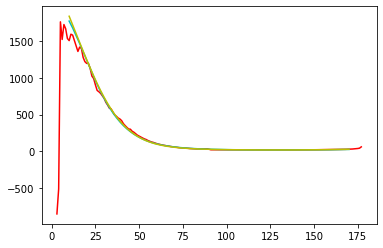

In [28]:
plt.plot(data_real['angle'],data_real['P11_uNeph'],'r')
plt.plot(data_real['angle'],data_real['P11_GRASP_lognorm'],'c')
plt.plot(data_real['angle'],data_real['P11_GRASP_binned'],'y')


In [29]:
plt.plot(data_real['angle'],data_real['P11_uNeph']*1e-12,'r')
plt.plot(data_real['angle'],data_real['P11_GRASP_lognorm']*1e-12,'c')
plt.plot(data_real['angle'],data_real['P11_GRASP_binned']*1e-12,'y')

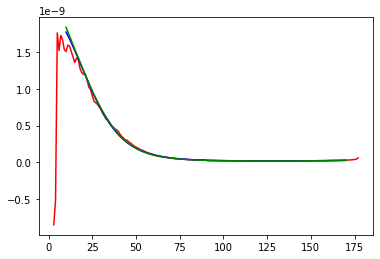

In [34]:
plt.plot(data_real['angle'],data_real['P11_uNeph']*1e-12,'r')
#plt.plot(phase_fun400['angle'],phase_fun400['P11 [1/um]'],'r')
plt.plot(phase_fun400_log['angle'],phase_fun400_log['P11'],'b')
plt.plot(phase_fun400_bin['angle'],phase_fun400_bin['P11'],'g')

/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


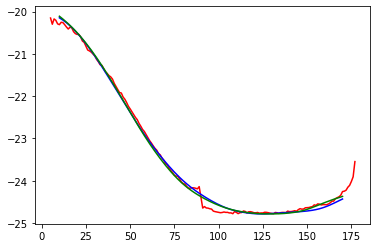

In [35]:
plt.plot(data_real['angle'],np.log(data_real['P11_uNeph']*1e-12),'r')
plt.plot(phase_fun400_log['angle'],np.log(phase_fun400_log['P11']),'b')
plt.plot(phase_fun400_bin['angle'],np.log(phase_fun400_bin['P11']),'g')

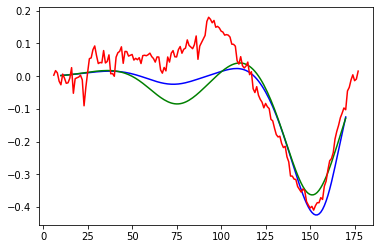

In [36]:
plt.plot(phase_fun400_log['angle'],phase_fun400_log['PPF'],'b')
plt.plot(phase_fun400_bin['angle'],phase_fun400_bin['PPF'],'g')
plt.plot(data_real['angle'].iloc[3:],data_real['PPF_uNeph'].iloc[3:],'r')

# transform real measurement data to right format

In [37]:
data400_P11 = pd.DataFrame(data=data_real['P11_uNeph']).transpose()
data400_P12 = pd.DataFrame(data=data_real['PPF_uNeph']).transpose()

phase400new_P11_log = pd.DataFrame(data = phase_fun400_log['P11']).transpose()
phase400new_P12_log = pd.DataFrame(data = phase_fun400_log['PPF']).transpose()
phase400new_P11_bin = pd.DataFrame(data = phase_fun400_bin['P11']).transpose()
phase400new_P12_bin = pd.DataFrame(data = phase_fun400_bin['PPF']).transpose()
data400_P11

0           1            2            3            4    \
P11_uNeph -856.143789 -514.938575  1766.402619  1525.443884  1729.773492   

                   5            6            7            8            9    \
P11_uNeph  1672.471319  1538.578323  1510.215538  1597.463275  1584.820141   

           ...        164        165        166        167        168  \
P11_uNeph  ...  25.815868  26.776699  29.214997  29.460967  30.158069   

                169        170        171        172        173  
P11_uNeph  32.34301  33.801426  37.058601  41.418983  59.313611  

[1 rows x 174 columns]

In [38]:
listindex_data1 = []
listindex_data2 = []
for i in range(len(data_real['angle'])):
    listindex_data1.append("P11_0.532_"+str(int(data_real['angle'].iloc[i])))
    listindex_data2.append("P12_0.532_"+str(int(data_real['angle'].iloc[i])))
    
listindex1_log = []
listindex2_log = []
for i in range(len(phase_fun400_log['angle'])):
    listindex1_log.append("P11_0.532_"+str(int(phase_fun400_log['angle'].iloc[i])))
    listindex2_log.append("P12_0.532_"+str(int(phase_fun400_log['angle'].iloc[i])))    

listindex1_bin = []
listindex2_bin = []
for i in range(len(phase_fun400_bin['angle'])):
    listindex1_bin.append("P11_0.532_"+str(int(phase_fun400_bin['angle'].iloc[i])))
    listindex2_bin.append("P12_0.532_"+str(int(phase_fun400_bin['angle'].iloc[i])))  
    
listindex_data1

['P11_0.532_3',
 'P11_0.532_4',
 'P11_0.532_5',
 'P11_0.532_6',
 'P11_0.532_7',
 'P11_0.532_8',
 'P11_0.532_9',
 'P11_0.532_10',
 'P11_0.532_11',
 'P11_0.532_12',
 'P11_0.532_13',
 'P11_0.532_14',
 'P11_0.532_15',
 'P11_0.532_16',
 'P11_0.532_17',
 'P11_0.532_18',
 'P11_0.532_19',
 'P11_0.532_20',
 'P11_0.532_21',
 'P11_0.532_22',
 'P11_0.532_23',
 'P11_0.532_24',
 'P11_0.532_25',
 'P11_0.532_26',
 'P11_0.532_27',
 'P11_0.532_28',
 'P11_0.532_29',
 'P11_0.532_30',
 'P11_0.532_31',
 'P11_0.532_32',
 'P11_0.532_33',
 'P11_0.532_34',
 'P11_0.532_35',
 'P11_0.532_36',
 'P11_0.532_37',
 'P11_0.532_38',
 'P11_0.532_39',
 'P11_0.532_40',
 'P11_0.532_41',
 'P11_0.532_42',
 'P11_0.532_43',
 'P11_0.532_44',
 'P11_0.532_45',
 'P11_0.532_46',
 'P11_0.532_47',
 'P11_0.532_48',
 'P11_0.532_49',
 'P11_0.532_50',
 'P11_0.532_51',
 'P11_0.532_52',
 'P11_0.532_53',
 'P11_0.532_54',
 'P11_0.532_55',
 'P11_0.532_56',
 'P11_0.532_57',
 'P11_0.532_58',
 'P11_0.532_59',
 'P11_0.532_60',
 'P11_0.532_61',
 'P1

In [39]:
dicts_data_1 = {}
j = 0
for i in data400_P11.columns:
    dicts_data_1[i]=listindex_data1[j]
    j=j+1
dicts_data_2 = {}
j = 0
for i in data400_P12.columns:
    dicts_data_2[i]=listindex_data2[j]
    j=j+1
dicts1_log = {}
j = 0
for i in phase400new_P11_log.columns:
        dicts1_log[i] = listindex1_log[j]
        j=j+1

dicts2_log = {}
j = 0
for i in phase400new_P12_log.columns:
        dicts2_log[i] = listindex2_log[j]
        j=j+1        
        
dicts1_bin = {}
j = 0
for i in phase400new_P11_bin.columns:
        dicts1_bin[i] = listindex1_bin[j]
        j=j+1

dicts2_bin = {}
j = 0
for i in phase400new_P12_bin.columns:
        dicts2_bin[i] = listindex2_bin[j]
        j=j+1  
dicts_data_1

{0: 'P11_0.532_3',
 1: 'P11_0.532_4',
 2: 'P11_0.532_5',
 3: 'P11_0.532_6',
 4: 'P11_0.532_7',
 5: 'P11_0.532_8',
 6: 'P11_0.532_9',
 7: 'P11_0.532_10',
 8: 'P11_0.532_11',
 9: 'P11_0.532_12',
 10: 'P11_0.532_13',
 11: 'P11_0.532_14',
 12: 'P11_0.532_15',
 13: 'P11_0.532_16',
 14: 'P11_0.532_17',
 15: 'P11_0.532_18',
 16: 'P11_0.532_19',
 17: 'P11_0.532_20',
 18: 'P11_0.532_21',
 19: 'P11_0.532_22',
 20: 'P11_0.532_23',
 21: 'P11_0.532_24',
 22: 'P11_0.532_25',
 23: 'P11_0.532_26',
 24: 'P11_0.532_27',
 25: 'P11_0.532_28',
 26: 'P11_0.532_29',
 27: 'P11_0.532_30',
 28: 'P11_0.532_31',
 29: 'P11_0.532_32',
 30: 'P11_0.532_33',
 31: 'P11_0.532_34',
 32: 'P11_0.532_35',
 33: 'P11_0.532_36',
 34: 'P11_0.532_37',
 35: 'P11_0.532_38',
 36: 'P11_0.532_39',
 37: 'P11_0.532_40',
 38: 'P11_0.532_41',
 39: 'P11_0.532_42',
 40: 'P11_0.532_43',
 41: 'P11_0.532_44',
 42: 'P11_0.532_45',
 43: 'P11_0.532_46',
 44: 'P11_0.532_47',
 45: 'P11_0.532_48',
 46: 'P11_0.532_49',
 47: 'P11_0.532_50',
 48: 'P11

In [40]:
newdata400_P11 = data400_P11.rename(dicts_data_1, axis =1)
newdata400_P12 = data400_P12.rename(dicts_data_2, axis =1)

newpdP11_log = phase400new_P11_log.rename(dicts1_log,axis = 1)
newpdP12_log = phase400new_P12_log.rename(dicts2_log,axis = 1)
newpdP11_bin = phase400new_P11_bin.rename(dicts1_bin,axis = 1)
newpdP12_bin = phase400new_P12_bin.rename(dicts2_bin,axis = 1)
newdata400_P11

P11_0.532_3  P11_0.532_4  P11_0.532_5  P11_0.532_6  P11_0.532_7  \
P11_uNeph  -856.143789  -514.938575  1766.402619  1525.443884  1729.773492   

           P11_0.532_8  P11_0.532_9  P11_0.532_10  P11_0.532_11  P11_0.532_12  \
P11_uNeph  1672.471319  1538.578323   1510.215538   1597.463275   1584.820141   

           ...  P11_0.532_168  P11_0.532_169  P11_0.532_170  P11_0.532_171  \
P11_uNeph  ...      25.815868      26.776699      29.214997      29.460967   

           P11_0.532_172  P11_0.532_173  P11_0.532_174  P11_0.532_175  \
P11_uNeph      30.158069       32.34301      33.801426      37.058601   

           P11_0.532_176  P11_0.532_177  
P11_uNeph      41.418983      59.313611  

[1 rows x 174 columns]

In [41]:
newdata400_P11 = newdata400_P11.rename({"P11_uNeph":'0'},axis=0)
newdata400_P12 = newdata400_P12.rename({"PPF_uNeph":'0'},axis=0)

newpdP12_log = newpdP12_log.rename({'PPF':'0'},axis = 0)
newpdP11_log = newpdP11_log.rename({'P11':'0'},axis = 0)
newpdP12_bin = newpdP12_bin.rename({'PPF':'0'},axis = 0)
newpdP11_bin = newpdP11_bin.rename({'P11':'0'},axis = 0)
newdata400_P11

P11_0.532_3  P11_0.532_4  P11_0.532_5  P11_0.532_6  P11_0.532_7  \
0  -856.143789  -514.938575  1766.402619  1525.443884  1729.773492   

   P11_0.532_8  P11_0.532_9  P11_0.532_10  P11_0.532_11  P11_0.532_12  ...  \
0  1672.471319  1538.578323   1510.215538   1597.463275   1584.820141  ...   

   P11_0.532_168  P11_0.532_169  P11_0.532_170  P11_0.532_171  P11_0.532_172  \
0      25.815868      26.776699      29.214997      29.460967      30.158069   

   P11_0.532_173  P11_0.532_174  P11_0.532_175  P11_0.532_176  P11_0.532_177  
0       32.34301      33.801426      37.058601      41.418983      59.313611  

[1 rows x 174 columns]

In [44]:
P11_column_names = list(filter(re.compile(".*P11").match, qoi_columns_fw))
P12_column_names = list(filter(re.compile(".*P12").match, qoi_columns_fw))
P11_column_names

['P11_0.532_10',
 'P11_0.532_11',
 'P11_0.532_12',
 'P11_0.532_13',
 'P11_0.532_14',
 'P11_0.532_15',
 'P11_0.532_16',
 'P11_0.532_17',
 'P11_0.532_18',
 'P11_0.532_19',
 'P11_0.532_20',
 'P11_0.532_21',
 'P11_0.532_22',
 'P11_0.532_23',
 'P11_0.532_24',
 'P11_0.532_25',
 'P11_0.532_26',
 'P11_0.532_27',
 'P11_0.532_28',
 'P11_0.532_29',
 'P11_0.532_30',
 'P11_0.532_31',
 'P11_0.532_32',
 'P11_0.532_33',
 'P11_0.532_34',
 'P11_0.532_35',
 'P11_0.532_36',
 'P11_0.532_37',
 'P11_0.532_38',
 'P11_0.532_39',
 'P11_0.532_40',
 'P11_0.532_41',
 'P11_0.532_42',
 'P11_0.532_43',
 'P11_0.532_44',
 'P11_0.532_45',
 'P11_0.532_46',
 'P11_0.532_47',
 'P11_0.532_48',
 'P11_0.532_49',
 'P11_0.532_50',
 'P11_0.532_51',
 'P11_0.532_52',
 'P11_0.532_53',
 'P11_0.532_54',
 'P11_0.532_55',
 'P11_0.532_56',
 'P11_0.532_57',
 'P11_0.532_58',
 'P11_0.532_59',
 'P11_0.532_60',
 'P11_0.532_61',
 'P11_0.532_62',
 'P11_0.532_63',
 'P11_0.532_64',
 'P11_0.532_65',
 'P11_0.532_66',
 'P11_0.532_67',
 'P11_0.532_68

In [64]:
newpdP11_log_1 = newpdP11_log[P11_column_names]
newpdP12_log_1 = newpdP12_log[P12_column_names]
newpdP11_bin_1 = newpdP11_bin[P11_column_names]
newpdP12_bin_1 = newpdP12_bin[P12_column_names]
newdata400_P11_1 = newdata400_P11[P11_column_names]
newdata400_P12_1 = newdata400_P12[P12_column_names]

In [65]:
newdata400_P11_1

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0   1510.215538   1597.463275   1584.820141   1509.136553   1428.869096   

   P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  ...  \
0   1362.245123   1422.066719   1402.911571    1279.54801   1222.652843  ...   

   P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  P11_0.532_165  \
0      21.396252      21.793549      22.344526      23.276415      23.298041   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  
0      24.699807      25.290593      25.815868      26.776699      29.214997  

[1 rows x 160 columns]

In [66]:
newdata400_P11_1 = np.log(newdata400_P11_1*1e-12)
newdata400_P11_1

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0    -20.311013    -20.254849    -20.262795    -20.311728    -20.366383   

   P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  ...  \
0    -20.414132    -20.371155    -20.384716    -20.476759    -20.522243  ...   

   P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  P11_0.532_165  \
0     -24.567805     -24.549407      -24.52444     -24.483581     -24.482652   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  
0     -24.424226     -24.400589     -24.380032     -24.343489     -24.256339  

[1 rows x 160 columns]

In [67]:
newpdP11_log_1 = np.log(newpdP11_log_1)
newpdP11_log_1

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0    -20.148621    -20.174451    -20.202688    -20.234318    -20.265904   

   P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  ...  \
0    -20.300878    -20.338003    -20.377268    -20.418505    -20.461825  ...   

   P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  P11_0.532_165  \
0     -24.607285     -24.590459     -24.572502     -24.553663     -24.533997   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  
0     -24.513779     -24.493225     -24.472617     -24.452176     -24.432226  

[1 rows x 160 columns]

In [68]:
newpdP11_bin_1 = np.log(newpdP11_bin_1)
newpdP11_bin_1

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0    -20.112034    -20.145193    -20.179257    -20.215665    -20.251077   

   P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  ...  \
0    -20.289084    -20.328525    -20.369375    -20.411672    -20.455378  ...   

   P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  P11_0.532_165  \
0     -24.499972     -24.483942     -24.468166     -24.453217     -24.439105   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  
0     -24.425393     -24.412145     -24.399387     -24.385776      -24.37085  

[1 rows x 160 columns]

In [ ]:
#phase400new5 = pd.concat([newpdP11_s,newpdP12_s],axis =1)


# Transform data from GRASP to the right format

In [70]:
#Measurement data to use:
qoi_test_fw.columns

Index(['P11_0.532_10', 'P11_0.532_11', 'P11_0.532_12', 'P11_0.532_13',
       'P11_0.532_14', 'P11_0.532_15', 'P11_0.532_16', 'P11_0.532_17',
       'P11_0.532_18', 'P11_0.532_19',
       ...
       'P11_0.532_161', 'P11_0.532_162', 'P11_0.532_163', 'P11_0.532_164',
       'P11_0.532_165', 'P11_0.532_166', 'P11_0.532_167', 'P11_0.532_168',
       'P11_0.532_169', 'P11_0.532_170'],
      dtype='object', length=160)

In [71]:
#real_measurement data:
newdata400_P11_1

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0    -20.311013    -20.254849    -20.262795    -20.311728    -20.366383   

   P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  ...  \
0    -20.414132    -20.371155    -20.384716    -20.476759    -20.522243  ...   

   P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  P11_0.532_165  \
0     -24.567805     -24.549407      -24.52444     -24.483581     -24.482652   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  
0     -24.424226     -24.400589     -24.380032     -24.343489     -24.256339  

[1 rows x 160 columns]

In [72]:
#P11_log from GRASP:
newpdP11_log_1

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0    -20.148621    -20.174451    -20.202688    -20.234318    -20.265904   

   P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  ...  \
0    -20.300878    -20.338003    -20.377268    -20.418505    -20.461825  ...   

   P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  P11_0.532_165  \
0     -24.607285     -24.590459     -24.572502     -24.553663     -24.533997   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  
0     -24.513779     -24.493225     -24.472617     -24.452176     -24.432226  

[1 rows x 160 columns]

In [73]:
#P11_bin from GRASP:
newpdP11_bin_1

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0    -20.112034    -20.145193    -20.179257    -20.215665    -20.251077   

   P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  ...  \
0    -20.289084    -20.328525    -20.369375    -20.411672    -20.455378  ...   

   P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  P11_0.532_165  \
0     -24.499972     -24.483942     -24.468166     -24.453217     -24.439105   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  
0     -24.425393     -24.412145     -24.399387     -24.385776      -24.37085  

[1 rows x 160 columns]

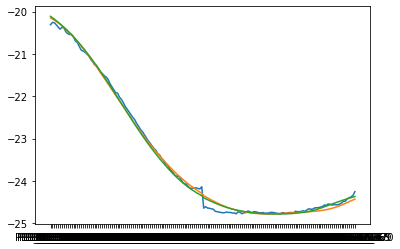

In [76]:
plt.plot(newdata400_P11_1.iloc[0])
plt.plot(newpdP11_log_1.iloc[0])
plt.plot(newpdP11_bin_1.iloc[0])

# Predict dvar from measurement data

In [96]:
## 4mal laufen lassen gibt bestes Resultat!!!
dvar_pred_fwiv = surr_fwiv.sample_n_tries(newdata400_P11_1.values, batch_size=128, n_tries=32)
dvar_pred_iv = surr_iv.predict(newdata400_P11_1.values)
dvar_pred_fwiv_log = surr_fwiv.sample_n_tries(newpdP11_log_1.values, batch_size=128, n_tries=32)
dvar_pred_iv_log = surr_iv.predict(newpdP11_log_1.values)
dvar_pred_fwiv_bin = surr_fwiv.sample_n_tries(newpdP11_bin_1.values, batch_size=128, n_tries=32)
dvar_pred_iv_bin = surr_iv.predict(newpdP11_bin_1.values)


In [97]:
dvar_pred_fwiv = pd.DataFrame(data = dvar_pred_fwiv, columns = dvar_columns_fw)
dvar_pred_fwiv_log = pd.DataFrame(data = dvar_pred_fwiv_log, columns = dvar_columns_fw)
dvar_pred_fwiv_bin = pd.DataFrame(data = dvar_pred_fwiv_bin, columns = dvar_columns_fw)
dvar_pred_iv = pd.DataFrame(data = dvar_pred_iv, columns = dvar_columns_fw)
dvar_pred_iv_log = pd.DataFrame(data = dvar_pred_iv_log, columns = dvar_columns_fw)
dvar_pred_iv_bin = pd.DataFrame(data = dvar_pred_iv_bin, columns = dvar_columns_fw)

In [98]:
dvar_pred_fwiv

V_tot  R_median       GSD   n_532nm   k_532nm
0 -60.295456  0.448085  1.413512  1.417963 -0.003228

In [99]:
dvar_pred_fwiv_log

V_tot  R_median       GSD   n_532nm   k_532nm
0 -4.645431   0.25001  1.418237  1.445185  0.004997

In [100]:
dvar_pred_fwiv_bin

V_tot  R_median       GSD   n_532nm   k_532nm
0  25.086306   0.36235  1.416916  1.400108 -0.004471

In [101]:
dvar_pred_iv

V_tot  R_median       GSD   n_532nm   k_532nm
0 -73.060997  0.169554  1.395161  1.398559 -0.011542

In [102]:
dvar_pred_iv_log

V_tot  R_median       GSD   n_532nm   k_532nm
0  340.524285  0.244181  1.416952  1.458628  0.013655

In [103]:
dvar_pred_iv_bin

V_tot  R_median       GSD   n_532nm   k_532nm
0  124.982674  0.240753  1.423187  1.426746  0.002272

# Compare to true values

In [114]:
np.exp(0.262)

1.2995265424293818

In [106]:
#true parameters according to Alireza from 7.2.2021 - ranges for training in brackets

Parameters1 = pd.DataFrame([])
n = 1.45    #[1.33, 1.6]
k = 1e-5    #[1e-4, 0.2]
m = n+1j*k 
sigma = np.exp(0.262) #=1.29[1.4, 1.45]    1.4
rmean = 0.25 #[0.15,250]     0.4 
Vtot = 20.106 #[1, 5000]
wavelength = 532


# GRASP P11 retrieval log
Parameters2 = pd.DataFrame([])
n2 = 1.44738
k2 = 0.29496E-03
Vtot2 = 20.15
rmean2 = 0.26567
sigma2 = 1.28

# GRASP P11, PPF retrieval
Parameters3 = pd.DataFrame([])
n3 = 1.44749
k3 = 0.17341E-03
Vtot3 = 20.13
rmean3 = 0.265
sigma3 = 1.27

In [107]:
Parameters1['V_tot']=[Vtot]
Parameters1['R_median']=rmean
Parameters1['GSD']=sigma
Parameters1['n']=n
Parameters1['k_532']=k

Parameters2['V_tot']=[Vtot2]
Parameters2['R_median']=rmean2
Parameters2['GSD']=sigma2
Parameters2['n']=n2
Parameters2['k_532']=k2

Parameters3['V_tot']=[Vtot3]
Parameters3['R_median']=rmean3
Parameters3['GSD']=sigma3
Parameters3['n']=n3
Parameters3['k_532']=k3

#Parameters3['V_tot']=[27.705646]
#Parameters3['R_median']=0.392594 
#Parameters3['GSD']=1.422337
#Parameters3['n']=n
#Parameters3['k_532']=0.012761



In [108]:
Parameters3

V_tot  R_median   GSD        n     k_532
0  20.13     0.265  1.27  1.44749  0.000173

In [111]:
Parameters2

V_tot  R_median   GSD        n     k_532
0  20.15   0.26567  1.28  1.44738  0.000295

In [112]:
Parameters1

V_tot  R_median       GSD     n    k_532
0  20.106      0.25  1.299527  1.45  0.00001

In [ ]:
# Parameter k_532 is not included in the original data set. 

In [113]:
def pdf(Vtot, x, mu, sigma):
    return Vtot/(np.sqrt(2*np.pi)*np.log(sigma))*np.exp(-(np.log(x)-np.log(mu))**2.0/(2*(np.log(sigma))**2.0))

$sizedistr(x)=\frac{ V_{tot}}{( \log(GSD) \sqrt{2 \pi})}\exp(\frac{-\log(x)-\log(R_{mean})^2} {(2 \log(GSD)^2)})$

In [ ]:
Parameters3

In [ ]:

mu1 = Parameters1['R_median'][0]
sigma1 = Parameters1['GSD'][0]
Vtot1 = Parameters1['V_tot'][0]
s1 = np.random.lognormal(mu1, sigma1, 10000)   
count1, bins1, ignored1 = plt.hist(s1, 10000, density=True, align='mid',histtype = 'step')
x1 = np.linspace(min(bins1), max(bins1), 100000)
#pdf1 = Vtot1*(np.exp(-(np.log(x1) - np.log(mu1))**2 / (2 * sigma1**2)) / ( sigma1 * np.sqrt(2 * np.pi)))
pdf1 = pdf(Vtot1,x1,mu1,sigma1)

fig, ax = plt.subplots(figsize = (10,10))
ax.plot(x1,pdf1)
ax.set_xscale('log')

In [ ]:
pdf1 = pdf(Vtot1,x_new,mu1,sigma1)

fig, ax = plt.subplots(figsize = (10,10))
ax.plot(x_new,pdf1)
ax.set_xscale('log')

In [ ]:
x_new =np.array([ 0.0655,0.0679,0.07035,0.07295,0.0756,0.07840000000000000,0.08125,0.08425,0.08735,0.09055000000000000,0.09385000000000000,0.0973,0.10085,0.10455,0.10835000000000000,0.11235000000000000,0.11645,0.1207,0.12515,0.12975,0.1345,0.1394,0.1445,0.14980000000000000,0.15530000000000000,0.161,0.1669,0.173,0.179350,0.1859,0.19270,0.19975,0.2071,0.2147,0.22255,0.2307,0.23915,0.2479,0.257,0.26640000000000000,0.27615000000000000,0.28625,0.29675,0.30765,0.31890000000000000,0.3306,0.3427,0.35525,0.36825,0.38175,0.39575,0.41025,0.42525,0.44085,0.457,0.47375])

In [ ]:

mu2 = dvar_pred_iv5['R_median'][0]
sigma2 = dvar_pred_iv5['GSD'][0]
Vtot2 = dvar_pred_iv5['V_tot'][0]
s2 = np.random.lognormal(mu2, sigma2, 10000)   
count2, bins2, ignored2 = plt.hist(s2, 10000, density=True, align='mid',histtype = 'step')
x2 = np.linspace(min(bins2), max(bins2), 100000)
#pdf2 = Vtot2*(np.exp(-(np.log(x2) - np.log(mu2))**2 / (2 * sigma2**2)) / (sigma2 * np.sqrt(2 * np.pi)))
pdf2 = pdf(Vtot2,x_new,mu2,sigma2)

mu3 = dvar_pred_iv13['R_median'][0]
sigma3 = dvar_pred_iv13['GSD'][0]
Vtot3 = dvar_pred_iv13['V_tot'][0]
s3 = np.random.lognormal(mu3, sigma3, 10000)   
count3, bins3, ignored3 = plt.hist(s3, 10000, density=True, align='mid',histtype = 'step')
x3 = np.linspace(min(bins3), max(bins3), 100000)
#pdf3 = Vtot3*(np.exp(-(np.log(x3) - np.log(mu3))**2 / (2 * sigma3**2)) / (sigma3 * np.sqrt(2 * np.pi)))
pdf3 = pdf(Vtot3,x_new,mu3,sigma3)


mu4 = dvar_pred_iv19['R_median'][0]
sigma4 = dvar_pred_iv19['GSD'][0]
Vtot4 = dvar_pred_iv19['V_tot'][0]
s4 = np.random.lognormal(mu4, sigma4, 10000)   
count4, bins4, ignored4 = plt.hist(s4, 10000, density=True, align='mid',histtype = 'step')
x4 = np.linspace(min(bins4), max(bins4), 100000)
#pdf4 = Vtot4*(np.exp(-(np.log(x4) - np.log(mu1))**2 / (2 * sigma4**2)) / (sigma4 * np.sqrt(2 * np.pi)))
pdf4 = pdf(Vtot4,x_new,mu4,sigma4)




fig, ax = plt.subplots(figsize = (10,10))
ax.plot(x_new,pdf2,'r')
ax.plot(x_new,pdf1,'b')
ax.plot(x_new,pdf3,'g')
ax.plot(x_new,pdf4,'k')
ax.set_xscale('log')

In [ ]:
mu1_2 = Parameters2['R_median'][0]
sigma1_2 = Parameters2['GSD'][0]
Vtot1_2 = Parameters2['V_tot'][0]
s1_2 = np.random.lognormal(mu1_2, sigma1_2, 10000)   
count1_2, bins1_2, ignored1_2 = plt.hist(s1_2, 10000, density=True, align='mid',histtype = 'step')
x1_2 = np.linspace(min(bins1_2), max(bins1_2), 100000)
#pdf1_2 = Vtot1_2*(np.exp(-(np.log(x1_2) - np.log(mu1_2))**2 / (2 * sigma1_2**2)) / ( sigma1_2 * np.sqrt(2 * np.pi)))
pdf1_2 = pdf(Vtot1_2,x_new,mu1_2,sigma1_2)

fig, ax = plt.subplots(figsize = (10,10))
ax.plot(x_new,pdf1_2*1000,'r')
ax.plot(x_new,pdf1*1000,'b')
ax.set_xscale('log')

In [ ]:
mu1_3 = Parameters3['R_median'][0]
sigma1_3 = Parameters3['GSD'][0]
Vtot1_3 = Parameters3['V_tot'][0]
s1_3 = np.random.lognormal(mu1_3, sigma1_3, 10000)   
count1_3, bins1_3, ignored1_3 = plt.hist(s1_3, 10000, density=True, align='mid',histtype = 'step')
x1_3 = np.linspace(min(bins1_3), max(bins1_3), 100000)
#pdf1_3 = Vtot1_3*(np.exp(-(np.log(x1_3) - np.log(mu1_3))**2 / (2 * sigma1_3**2)) / (sigma1_2 * np.sqrt(2 * np.pi)))
pdf1_3 = pdf(Vtot1_3,x_new,mu1_3,sigma1_3)

fig, ax = plt.subplots(figsize = (10,10))
ax.plot(x_new,pdf1_3*1000,'r')
ax.plot(x_new,pdf1*1000,'b')
ax.set_xscale('log')

In [ ]:
fig, ax = plt.subplots(figsize = (10,7))

ax.plot(x_new,pdf1,'b',label='measurement')
ax.plot(x_new,pdf3,'g',label='retrieved aerosol properties with P11')

ax.set_xscale('log')
plt.legend(fontsize=15 )
plt.xticks(fontsize =15)
plt.xlabel('radius r',fontsize=15)
plt.ylabel('dV/dlog(r)',fontsize=15)

In [ ]:
fig, ax = plt.subplots(figsize = (10,7))

ax.plot(x_new,pdf1,'b',label='measurement')
ax.plot(x_new,pdf1_2,'r',label='GRASP retrieved aerosol properties with P11')
ax.plot(x_new,pdf1_3,'y',label='GRASP retrieved aerosol properties with P11 and PPF')

ax.plot(x_new,pdf3,'g',label='retrieved aerosol properties with P11')

ax.set_xscale('log')
plt.legend(fontsize=15 , bbox_to_anchor=(1,1))
plt.xticks(fontsize =15)
plt.xlabel('radius r',fontsize=15)
plt.ylabel('dV/dlog(r)',fontsize=15)

# Recompute phase functions

In [ ]:
qoi_pred_iv_meas5_P1 = surr5.predict(Parameters1)
qoi_pred_iv_meas5_P1 =pd.DataFrame(qoi_pred_iv_meas5_P1,columns= qoi_test5.columns)


qoi_pred_iv_meas5 = surr5.predict(dvar_pred_iv5)
qoi_pred_iv_meas5 =pd.DataFrame(qoi_pred_iv_meas5,columns= qoi_test5.columns)

qoi_pred_iv_meas13 = surr13.predict(dvar_pred_iv13)
qoi_pred_iv_meas13 =pd.DataFrame(qoi_pred_iv_meas13,columns= qoi_test13.columns)

qoi_pred_iv_meas19 = surr19.predict(dvar_pred_iv19)
qoi_pred_iv_meas19 =pd.DataFrame(qoi_pred_iv_meas19,columns= qoi_test19.columns)


In [ ]:
qoi_pred_iv_meas5_P2 = surr5.predict(Parameters2)
qoi_pred_iv_meas5_P2 =pd.DataFrame(qoi_pred_iv_meas5_P2,columns= qoi_test5.columns)

qoi_pred_iv_meas5_P3 = surr5.predict(Parameters3)
qoi_pred_iv_meas5_P3 =pd.DataFrame(qoi_pred_iv_meas5_P3,columns= qoi_test5.columns)




In [ ]:
qoi_pred_iv_meas5_P1

In [ ]:
angles_plot0 = np.arange(5,85)
angles_plot1 = np.arange(96,176)
angles_plot = np.concatenate([angles_plot0 ,angles_plot1])
angles_plot

In [ ]:
plt.figure(figsize =(10,5))
plt.plot(angles_plot,qoi_pred_iv_meas5[P11_column_names].iloc[0],'k',label="predicted from retrieved aerosol properties with P11 and PPF")

plt.plot(angles_plot,qoi_pred_iv_meas5_P1[P11_column_names].iloc[0],'r', label="predicted from known aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas13[P11_column_names].iloc[0],'g', label ="predicted from retrieved aerosol properties with P11")


plt.plot(angles_plot,newdata400_c[P11_column_names].iloc[0],'b',label= "measurement data")

plt.plot(phase_fun400_log['angle'],np.log(phase_fun400_log['P11']),'y',label="predicted from GRASP retrieved aerosol properties lognormal")
plt.plot(phase_fun400_bin['angle'],np.log(phase_fun400_bin['P11']),'c',label= "predicted from GRASP retrieved aerosol properties binned")
plt.legend(fontsize=12)
plt.ylabel("log(P_11)",fontsize=15)
plt.xlabel("angles",fontsize=15)

plt.xticks(fontsize =15)
plt.yticks(fontsize =15)

In [ ]:
plt.figure(figsize =(10,5))
#plt.plot(angles_plot,qoi_pred_iv_meas5[P11_column_names].iloc[0],'b',label="predicted from retrieved aerosol properties with P11 and PPF")

plt.plot(angles_plot,qoi_pred_iv_meas5_P1[P11_column_names].iloc[0],'r', label="predicted from known aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas13[P11_column_names].iloc[0],'g', label ="predicted from retrieved aerosol properties with P11")


plt.plot(angles_plot,newdata400_c[P11_column_names].iloc[0],'k',label= "measurement data")

plt.plot(phase_fun400_log['angle'],np.log(phase_fun400_log['P11']),'y',label="predicted from GRASP retrieved aerosol properties lognormal")
plt.plot(phase_fun400_bin['angle'],np.log(phase_fun400_bin['P11']),'c',label= "predicted from GRASP retrieved aerosol properties binned")
plt.legend(fontsize=12)
plt.ylabel("log(P_11)",fontsize=15)
plt.xlabel("angles",fontsize=15)

plt.xticks(fontsize =15)
plt.yticks(fontsize =15)





In [ ]:
plt.figure(figsize =(10,5))
#plt.plot(angles_plot,qoi_pred_iv_meas5[P11_column_names].iloc[0],'b.',label="predicted from retrieved aerosol properties with P11 and PPF")

plt.plot(angles_plot,qoi_pred_iv_meas5_P1[P11_column_names].iloc[0],'r.', label="predicted from known aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas13[P11_column_names].iloc[0],'g.', label ="predicted from retrieved aerosol properties with P11")




plt.plot(phase_fun400_bin['angle'],np.log(phase_fun400_bin['P11']),'c.',label= "predicted from GRASP retrieved aerosol properties binned")
plt.plot(phase_fun400_log['angle'],np.log(phase_fun400_log['P11']),'y.',label="predicted from GRASP retrieved aerosol properties lognormal")
plt.plot(angles_plot,newdata400_c[P11_column_names].iloc[0],'b.',label= "measurement data")

plt.legend(fontsize=12)
plt.ylabel("log(P_11)",fontsize=15)
plt.xlabel("angles",fontsize=15)

plt.xticks(fontsize =15)
plt.yticks(fontsize =15)

In [ ]:
Parameters3

In [ ]:
plt.figure(figsize =(10,5))
#plt.plot(angles_plot,qoi_pred_iv_meas5[P11_column_names].iloc[0],'b.',label="predicted from retrieved aerosol properties with P11 and PPF")

plt.plot(angles_plot,qoi_pred_iv_meas5_P1[P11_column_names].iloc[0],'r.', label="predicted from known aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas5_P2[P11_column_names].iloc[0],'k.', label="predicted from GRASP 1 aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas5_P3[P11_column_names].iloc[0],'k*', label="predicted from GRASP 2 aerosol properties with P11 and PPF")


plt.plot(angles_plot,qoi_pred_iv_meas13[P11_column_names].iloc[0],'g.', label ="predicted from retrieved aerosol properties with P11")

plt.plot(phase_fun400_bin['angle'],np.log(phase_fun400_bin['P11']),'c.',label= "predicted from GRASP retrieved aerosol properties binned")
plt.plot(phase_fun400_log['angle'],np.log(phase_fun400_log['P11']),'y.',label="predicted from GRASP retrieved aerosol properties lognormal")
plt.plot(angles_plot,newdata400_c[P11_column_names].iloc[0],'b.',label= "measurement data")

plt.legend(fontsize=12)
plt.ylabel("log(P_11)",fontsize=15)
plt.xlabel("angles",fontsize=15)

plt.xticks(fontsize =15)
plt.yticks(fontsize =15)

In [ ]:
plt.figure(figsize =(10,5))
#plt.plot(angles_plot,qoi_pred_iv_meas5[P11_column_names].iloc[0],'b.',label="predicted from retrieved aerosol properties with P11 and PPF")

plt.plot(angles_plot,qoi_pred_iv_meas5_P1[P11_column_names].iloc[0],'r', label="predicted from known aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas5_P2[P11_column_names].iloc[0],'k', label="predicted from GRASP 1 aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas5_P3[P11_column_names].iloc[0],'k', label="predicted from GRASP 2 aerosol properties with P11 and PPF")


plt.plot(angles_plot,qoi_pred_iv_meas13[P11_column_names].iloc[0],'g', label ="predicted from retrieved aerosol properties with P11")

plt.plot(phase_fun400_bin['angle'],np.log(phase_fun400_bin['P11']),'c',label= "predicted from GRASP retrieved aerosol properties binned")
plt.plot(phase_fun400_log['angle'],np.log(phase_fun400_log['P11']),'y',label="predicted from GRASP retrieved aerosol properties lognormal")
plt.plot(angles_plot,newdata400_c[P11_column_names].iloc[0],'b',label= "measurement data")

plt.legend(fontsize=12)
plt.ylabel("log(P_11)",fontsize=15)
plt.xlabel("angles",fontsize=15)

plt.xticks(fontsize =15)
plt.yticks(fontsize =15)

In [ ]:
plt.figure(figsize =(10,5))
plt.plot(angles_plot,qoi_pred_iv_meas5[P12_column_names].iloc[0],'k.',label="predicted from retrieved aerosol properties with P11 and PPF")

plt.plot(angles_plot,qoi_pred_iv_meas5_P1[P12_column_names].iloc[0],'r.', label="predicted from known aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas19[P12_column_names].iloc[0],'g.', label ="predicted from retrieved aerosol properties with P11")


plt.plot(angles_plot,newdata400_c[P12_column_names].iloc[0],'b.',label= "measurement data")


plt.plot(phase_fun400_log['angle'],(phase_fun400_log['PPF']),'y.',label="predicted from GRASP retrieved aerosol properties lognormal")
plt.plot(phase_fun400_bin['angle'],(phase_fun400_bin['PPF']),'c.',label= "predicted from GRASP retrieved aerosol properties binned")
plt.legend(fontsize=10)
plt.ylabel("PPF",fontsize=15)
plt.xlabel("angles",fontsize=15)




plt.xticks(fontsize =15)
plt.yticks(fontsize =15)



In [ ]:
plt.figure(figsize =(10,5))
plt.plot(angles_plot,qoi_pred_iv_meas5[P12_column_names].iloc[0],'k',label="predicted from retrieved aerosol properties with P11 and PPF")

plt.plot(angles_plot,qoi_pred_iv_meas5_P1[P12_column_names].iloc[0],'r', label="predicted from known aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas19[P12_column_names].iloc[0],'g', label ="predicted from retrieved aerosol properties with P12")


plt.plot(angles_plot,newdata400_c[P12_column_names].iloc[0],'b',label= "measurement data")



plt.plot(phase_fun400_log['angle'],(phase_fun400_log['PPF']),'y',label="predicted from GRASP retrieved aerosol properties lognormal")
plt.plot(phase_fun400_bin['angle'],(phase_fun400_bin['PPF']),'c',label= "predicted from GRASP retrieved aerosol properties binned")
plt.legend()
plt.ylabel("PPF")
plt.xlabel("angles")

In [ ]:
plt.figure(figsize =(10,5))
#plt.plot(angles_plot,qoi_pred_iv_meas5[P12_column_names].iloc[0],'b',label="predicted from retrieved aerosol properties with P11 and PPF")

plt.plot(angles_plot,qoi_pred_iv_meas5_P1[P12_column_names].iloc[0],'r', label="predicted from known aerosol properties with P11 and PPF")
#plt.plot(angles_plot,qoi_pred_iv_meas19[P12_column_names].iloc[0],'g', label ="predicted from retrieved aerosol properties with P12")


plt.plot(angles_plot,newdata400_c[P12_column_names].iloc[0],'k',label= "measurement data")



plt.plot(phase_fun400_log['angle'],(phase_fun400_log['PPF']),'y',label="predicted from GRASP retrieved aerosol properties lognormal")
plt.plot(phase_fun400_bin['angle'],(phase_fun400_bin['PPF']),'c',label= "predicted from GRASP retrieved aerosol properties binned")
plt.legend(fontsize=10)
plt.ylabel("PPF",fontsize=15)
plt.xlabel("angles",fontsize=15)




plt.xticks(fontsize =15)
plt.yticks(fontsize =15)


In [ ]:
plt.figure(figsize =(10,5))
#plt.plot(angles_plot,qoi_pred_iv_meas5[P11_column_names].iloc[0],'b.',label="predicted from retrieved aerosol properties with P11 and PPF")

plt.plot(angles_plot,qoi_pred_iv_meas5_P1[P11_column_names].iloc[0],'r.', label="predicted from known aerosol properties with P11 and PPF")
#plt.plot(angles_plot,qoi_pred_iv_meas5_P2[P11_column_names].iloc[0],'k', label="predicted from GRASP 1 aerosol properties with P11 and PPF")
plt.plot(angles_plot,qoi_pred_iv_meas5_P3[P11_column_names].iloc[0],'k.', label="predicted from retrieved aerosol properties with P11 and replacing n with n=1.45")


plt.plot(angles_plot,qoi_pred_iv_meas13[P11_column_names].iloc[0],'g.', label ="predicted from retrieved aerosol properties with P11")

plt.plot(phase_fun400_bin['angle'],np.log(phase_fun400_bin['P11']),'c.',label= "predicted from GRASP retrieved aerosol properties binned")
plt.plot(phase_fun400_log['angle'],np.log(phase_fun400_log['P11']),'y.',label="predicted from GRASP retrieved aerosol properties lognormal")
plt.plot(angles_plot,newdata400_c[P11_column_names].iloc[0],'b.',label= "measurement data")

plt.legend(fontsize=12,bbox_to_anchor = (1,1))
plt.ylabel("log(P_11)",fontsize=15)
plt.xlabel("angles",fontsize=15)

plt.xticks(fontsize =15)
plt.yticks(fontsize =15)

In [ ]:
qoi_pred_iv_meas5_P2.columns